# Custom Modeling

Script to test the custom modeling .py scripts

## Imports

In [1]:
# imports 
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder,PolynomialFeatures

import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Metric Definition

In [2]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

### Modeling Custom Function

In [3]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=400, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data Load

In [5]:
# Train Data
train = pd.read_csv('input/train.csv')

# Test Data
test = pd.read_csv('input/test.csv')

# Submission Data
sub = pd.read_csv('input/sample_submission.csv')

#General Data
structures = pd.read_csv('input/structures.csv')

## EDA

In [6]:
# We take a first look at the dataset
train.info()
print ('#################################################')
print ('#################################################')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4658147 entries, 0 to 4658146
Data columns (total 6 columns):
id                          int64
molecule_name               object
atom_index_0                int64
atom_index_1                int64
type                        object
scalar_coupling_constant    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 213.2+ MB
#################################################
#################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505542 entries, 0 to 2505541
Data columns (total 5 columns):
id               int64
molecule_name    object
atom_index_0     int64
atom_index_1     int64
type             object
dtypes: int64(3), object(2)
memory usage: 95.6+ MB


## Feature Engineering

In [7]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df


train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

'''
This will create 2 features:

    1) will show the first letter of `type`
    2) Will show the rest of characters
'''

train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')


train[f'molecule_type_dist_mean'] = train.groupby(['molecule_name', 'type'])['dist'].transform('mean')
test[f'molecule_type_dist_mean'] = test.groupby(['molecule_name', 'type'])['dist'].transform('mean')


In [8]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

In [9]:
train = create_features(train)
test = create_features(test)

Mem. usage decreased to 888.47 Mb (67.5% reduction)
Mem. usage decreased to 463.56 Mb (68.1% reduction)


### Correlation Check

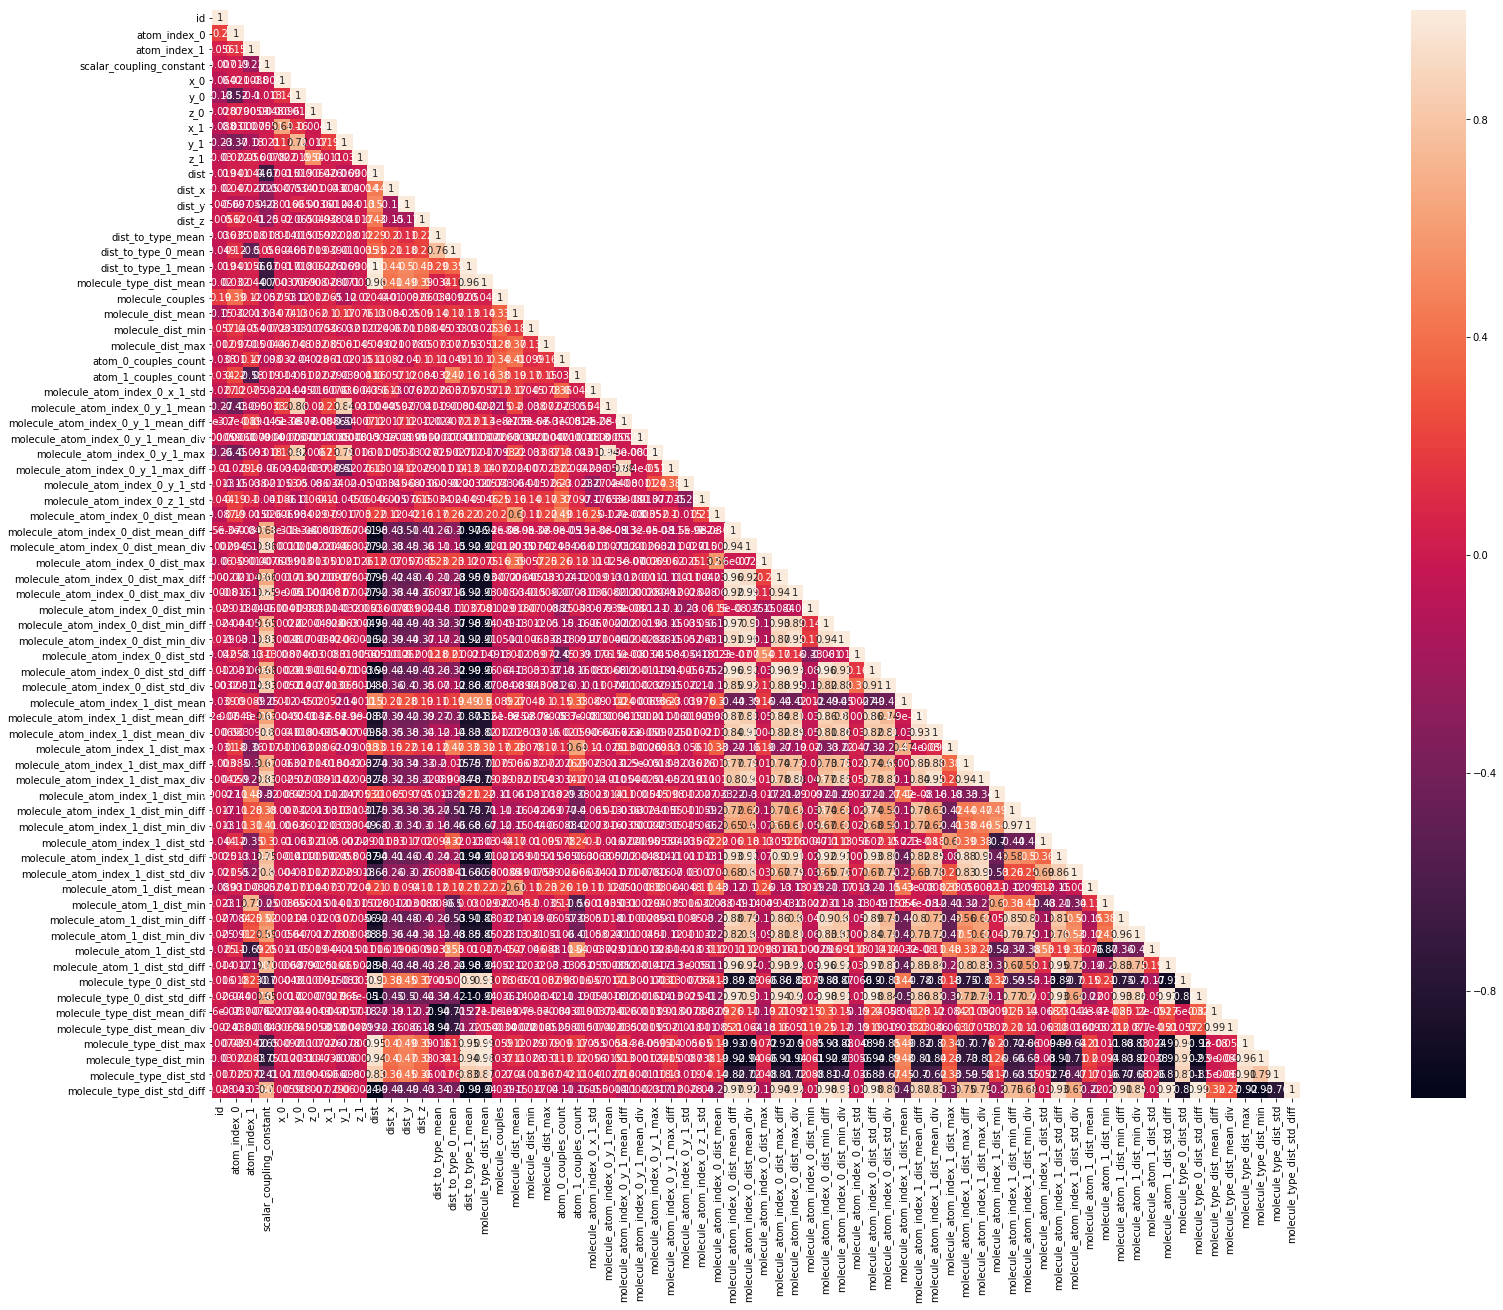

In [10]:
# Correlation Matrix Tr
cor_mat_train= train.corr()

mask_train = np.array(cor_mat_train)
mask_train[np.tril_indices_from(mask_train)] = False

fig_train=plt.gcf()
fig_train.set_size_inches(40,20)

sns.heatmap(data=cor_mat_train,mask=mask_train,square=True,annot=True,cbar=True)

### Label Encoding

In [11]:
categoricals = train.select_dtypes(include='object').columns
categoricals = test.select_dtypes(include='object').columns

# Train Categoricals
for c in categoricals:
    lbl = LabelEncoder()
    lbl.fit(list(train[c].values))
    train[c] = lbl.transform(list(train[c].values))

# Test Categoricals
for c in categoricals:
    lbl = LabelEncoder()
    lbl.fit(list(test[c].values))
    test[c] = lbl.transform(list(test[c].values))

## Modeling

#### Label Define

In [12]:
# We define the label
y = train['scalar_coupling_constant']

#### Drop Columns

In [13]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

In [14]:
X = train[good_columns].copy()
X_test = test[good_columns].copy()

In [15]:
# XGB Matrix Creation
dtrain = xgb.DMatrix(X, label=y)

#### K-Folds

In [16]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = KFold(n_splits=5, shuffle=True, random_state=8)

#### Parameter Tuning

In [17]:
params = {'booster' : 'gbtree',
    # Parameters that we are going to tune.
    'max_depth':8,
    'min_child_weight': 1,
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric' : 'mae',
}

#### Model Training

In [18]:
result_dict_xgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=skf, model_type='xgb', eval_metric='group_mae', plot_feature_importance=True,
                                        verbose=1000, early_stopping_rounds=16, n_estimators=10000)

Fold 1 started at Tue Jul 23 16:57:07 2019
[16:58:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-mae:13.0278	valid_data-mae:13.0307
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[16:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[17:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[17:03:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra no

[18:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[18:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[18:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[18:09:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[18:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=8
[18:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[18:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[18:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[18:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned no

[19:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[19:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[19:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=8
[19:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[19:24:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[19:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[19:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[19:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[19:28:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned no

[20:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=8
[20:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[20:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[20:35:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[20:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[20:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[20:38:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[20:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[20:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned no

[21:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[21:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[21:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[21:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[21:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[21:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[21:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[21:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[21:50:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned no

[22:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[22:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[22:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[22:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[22:56:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[22:57:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=8
[22:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[22:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[23:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned no

[00:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[00:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[00:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[00:05:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[00:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[00:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[00:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[00:09:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[00:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned no

[01:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[01:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[01:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[01:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[01:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[01:17:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[01:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[01:19:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[01:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned no

[02:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[02:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[02:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[02:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[02:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[02:27:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[02:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[02:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[02:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned no

[03:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=8
[03:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[03:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[03:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[03:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[03:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[03:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[03:39:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[03:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned no

[04:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[04:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[04:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[04:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[04:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[04:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[04:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[04:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[04:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned no

[05:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[05:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[399]	train-mae:1.04686	valid_data-mae:1.12978
Fold 3 started at Wed Jul 24 05:56:09 2019
[05:57:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-mae:13.0224	valid_data-mae:13.0529
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[05:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[05:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[06:00:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=8
[06:01:31] src/tree/updater_prune

[07:04:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[07:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[07:06:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[07:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[07:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[07:09:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[07:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[07:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[07:12:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned no

[08:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[08:18:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=8
[08:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[08:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[08:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[08:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[08:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[08:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[08:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned no

[09:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[09:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[09:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[09:35:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[09:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=8
[09:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=8
[09:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[09:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[09:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned no

[10:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[10:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[10:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[11:01:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[11:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[11:03:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[11:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[11:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[11:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned no

[12:15:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[12:16:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[12:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[12:18:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[12:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=8
[12:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[12:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[12:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[12:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned no

[13:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[13:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[13:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[13:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[13:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[13:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=8
[13:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[13:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[13:34:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned no

[14:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[14:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[14:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[14:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[14:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[14:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=8
[14:44:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[14:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[14:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned no

[15:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[15:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[15:56:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[15:57:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[15:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[16:00:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[16:01:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=8
[16:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[16:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned no

[17:11:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[17:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[17:13:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[17:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[17:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[17:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[17:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[17:18:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[17:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned no

[18:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[18:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[18:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[18:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[18:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[18:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[18:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[18:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[18:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned no

[19:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[19:36:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[19:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=8
[19:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[19:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[399]	train-mae:1.05129	valid_data-mae:1.13227
Fold 5 started at Wed Jul 24 19:41:52 2019
[19:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-mae:13.0368	valid_data-mae:12.9931
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[19:44:24] src/tree/updater_prune

[20:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[20:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[20:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[20:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[20:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[20:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[20:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[20:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[20:54:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned no

[21:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[21:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[21:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[21:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[22:00:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[22:01:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[22:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[22:03:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[22:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned no

[23:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[23:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[23:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[23:09:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=8
[23:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[23:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[23:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[23:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[23:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned no

[00:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[00:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[00:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[00:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[00:21:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[00:22:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[00:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[00:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned no

[01:27:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[01:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[01:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=8
[01:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[01:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=8
[01:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[01:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=8
[01:34:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[01:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned no

## Submission

In [19]:
sub['scalar_coupling_constant'] = result_dict_xgb['prediction']

In [20]:
sub.head()

,id,scalar_coupling_constant
0,4658147,10.842206
1,4658148,184.775519
2,4658149,7.423214
3,4658150,181.076843
4,4658151,6.425253


In [21]:
sub.to_csv('TRR_c_XGB_Molecular_Properties_2.csv', index=False)

Score of -0.126

## Plot oof VS target

In [ ]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_xgb['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)